In [3]:
!python3.7 -m pip install transformers==4.9.2

You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.


In [13]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from collections import defaultdict

%matplotlib inline

In [14]:
%config Completer.use_jedi = False

In [4]:
import pandas as pd
import numpy as np
from transformers import GPT2LMHeadModel, GPT2Tokenizer


model_name_or_path = "sberbank-ai/rugpt3large_based_on_gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name_or_path)
# model = GPT2LMHeadModel.from_pretrained(model_name_or_path).cuda()

In [7]:
BASE_PATH = "data/"

In [8]:
train_data = pd.read_csv(BASE_PATH + 'rus_train_dataset.csv', encoding='utf-8', sep='|')
en_ru_aux_data = pd.read_csv(BASE_PATH + 'en_to_rus_train_dataset.csv', encoding='utf-8', sep='|')

In [32]:
%%time
train_bundle = np.load(BASE_PATH + 'train_dataset_bundle.npy', allow_pickle=True)

CPU times: user 540 ms, sys: 975 ms, total: 1.52 s
Wall time: 2.02 s


In [34]:
train_bundle[0]

{'q': {'tokens': array([[ 4182,  7291, 13004, 18112,  1612,  7977,   282,  3723,   707,
             35]]),
  'likelihood': 55.590515,
  'embed': array([[[-0.10105464,  0.01616081,  0.42873275, ..., -0.10581393,
            1.0124849 , -0.6411731 ],
          [ 0.07145833, -0.48871338,  0.47270167, ...,  0.35405552,
            0.0315832 ,  0.05505302],
          [-0.3825777 ,  0.09196834, -0.23344886, ..., -0.5369391 ,
           -0.18912771, -0.5008245 ],
          ...,
          [ 0.5705487 , -0.1342039 ,  0.20777151, ..., -1.1217256 ,
            1.155151  ,  0.0294059 ],
          [-0.3563176 , -0.388275  , -0.42374414, ..., -0.4476165 ,
            0.7153409 , -0.28883162],
          [-1.1544749 , -0.06022687, -0.30357346, ..., -0.47898966,
            0.8051275 ,  0.32764208]]], dtype=float32)},
 'a1': {'tokens': array([[ 4182,  7291, 13004, 18112,  1612,  7977,   282,  3723,   707,
             35,  9266,   277]]),
  'likelihood': 67.78197,
  'embed': array([[[-0.10105464,  0.0

(array([1447.,    0.,    0.,    0.,    0., 1303.,    0.,    0.,    0.,
        1311.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

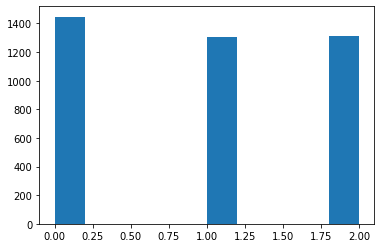

In [15]:
plt.hist(train_data["right_answer_id"].values)

In [27]:
from collections import Counter
Counter(en_ru_aux_data["right_answer_id"].values)

Counter({'2.0': 626,
         '0.0': 390,
         '1.0': 626,
         nan: 69,
         '0,0': 210,
         'right_answer_id': 2,
         '1,0': 14,
         '2,0': 3,
         '1.0.': 1})

(array([ 71.,   0.,   0., 600.,   0.,   0., 641.,   0.,   0., 629.]),
 array([-1. , -0.7, -0.4, -0.1,  0.2,  0.5,  0.8,  1.1,  1.4,  1.7,  2. ]),
 <BarContainer object of 10 artists>)

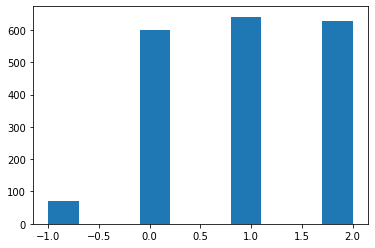

In [29]:
def _fix_input(x):
    if x in ['0.0', '1.0', '2.0', '0,0', '1,0', '2,0', '1.0.']:
        return float(x[0])
    return -1
plt.hist([_fix_input(x) for x in en_ru_aux_data["right_answer_id"].values])

In [43]:
def evaluate(generator, pipe, aggregator):
    for _split in generator:
        aggregator(pipe(_split))

In [169]:
from scipy.stats import norm

def p_val(x):
    return 2 * min(norm.cdf(-x), norm.cdf(x))

class ScoreAggregator:
    def __init__(self, baselines: np.array=None):
        self._scores = []
        self._baselines = baselines
    def __call__(self, score):
        self._scores.append(score)
    def calc_info(self):
        if self._baselines is None:
            self._baselines = self._scores
        diff = np.array(self._scores) - self._baselines
        return {"mean_score": np.mean(self._scores), "std_score": np.std(self._scores),
               "mean_diff": np.mean(diff), "std_diff": np.std(diff), "p_value": p_val(np.mean(diff) / (np.std(diff) + 1e-9))}
    
    def get_scores(self):
        return self._scores

In [463]:
train_raw_targets = train_data["right_answer_id"].values
def extract_targets_in_domain(idxs: np.array, is_pairwise: bool) -> np.array:
    if not is_pairwise:
        return train_raw_targets[idxs]
    targets = np.zeros(len(idxs) * 3)
    for i, t in enumerate(train_raw_targets[idxs]):
        targets[3*i + t] = 1
    return targets

In [462]:
np.arange(5) // 3

array([0, 0, 0, 1, 1])

In [57]:
train_bundle[0]['q']['embed'].shape

(1, 10, 1536)

In [62]:
train_bundle[0]['q']['tokens']

array([[ 4182,  7291, 13004, 18112,  1612,  7977,   282,  3723,   707,
           35]])

In [58]:
train_bundle[1]['q']['embed'].shape

(1, 12, 1536)

In [61]:
train_bundle[1]['q']['tokens']

array([[46928,   411, 22672,  3541,  5511,  1888, 26756, 26109,  2422,
          334, 40730,    35]])

In [239]:
train_bundle[0]['q']['embed'][0][-1].reshape(-1).shape

(1536,)

In [572]:
H = 32
np.random.seed(0)
random_proj = np.random.normal(size=(1536, H))
np.mean(random_proj)

-0.003485747948384979

In [371]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [573]:
tf_idf_vectorizer = TfidfVectorizer()

In [370]:
tf_idf_train = tf_idf_vectorizer.fit_transform(train_data["question"].values)

In [574]:
svd = TruncatedSVD(n_components=16, random_state=0)

In [575]:
tf_idf_train_svd_projected = svd.fit_transform(tf_idf_train)

In [665]:
def make_emb_random_proj(emb: np.array):
    emb_proj = np.matmul(emb, random_proj)
    emb_proj /= np.sum(np.abs(emb_proj))
    return emb_proj

def extract_features_in_domain_v1_impl(idx: int) -> np.array:

    return vec

def extract_features_in_domain_v1(idxs: np.array, reset_cache: bool=True, is_pairwise: bool=False,_cache=dict()) -> np.array:
    res = []
    if reset_cache:
        _cache = dict()
    for idx in idxs:
        if idx in _cache:
            vec = _cache[idx]
        else:
            emb = train_bundle[idx]['q']['embed'][0][-1].reshape(-1)
        #         emb /= np.sum(np.abs(emb))
            emb_proj = make_emb_random_proj(emb)
            tf_idf_emb = tf_idf_train_svd_projected[idx]
            tf_idf_emb /= np.sum(np.abs(tf_idf_emb))

            ll = np.array([
                train_bundle[idx]['a1']['likelihood'],
                train_bundle[idx]['a2']['likelihood'],
                train_bundle[idx]['a3']['likelihood'],
            ])
            embs = np.array([
                train_bundle[idx]['a1']['embed'][0][-1].reshape(-1),
                train_bundle[idx]['a2']['embed'][0][-1].reshape(-1),
                train_bundle[idx]['a3']['embed'][0][-1].reshape(-1),
            ])
            
            dists = np.sum(np.abs(embs - emb), axis=1)
            
            ll = (ll - np.mean(ll)) / np.std(ll)
            vec = np.concatenate([
                [np.argmax(ll)],
                tf_idf_emb,
        #         emb_proj,
            ])
        _cache[idx] = vec
        if not is_pairwise:
            res.append(vec)
        else:
            for j in range(3):
                emb_a = embs[j]
                res.append(np.concatenate([
                    vec,
                    make_emb_random_proj(emb_a),
                    np.array([dists[j], j == np.argmin(dists)]),
                    np.array([ll[j], j == np.argmax(ll)]),
                ]))
    return np.array(res)

In [666]:
f = extract_features_in_domain_v1([0], True, True)
f.shape, f[:, -4:]

((3, 53),
 array([[ 7.51196960e+02,  0.00000000e+00,  1.20351601e+00,
          1.00000000e+00],
        [ 6.59161133e+02,  1.00000000e+00, -1.24492359e+00,
          0.00000000e+00],
        [ 7.81341492e+02,  0.00000000e+00,  4.14047353e-02,
          0.00000000e+00]]))

In [619]:
import catboost

In [620]:
def fit_predict_with_model(model, X_train, X_val, X_test, y_train, y_val, val_ratio: float, is_pairwise: bool):
    train_group_id = np.repeat(np.arange(X_train.shape[0] // 3), 3) if is_pairwise else None
    val_group_id = np.repeat(np.arange(X_val.shape[0] // 3), 3) if is_pairwise else None
    train_pool = catboost.Pool(X_train, y_train, group_id=train_group_id)
    val_pool = catboost.Pool(X_val, y_val, group_id=val_group_id)
    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100)
    return model.predict(X_test)
#     return X_test[:, 0]

def calc_metric(y_true, y_score, is_pairwise: bool):
    if not is_pairwise:
        return np.mean(y_true == y_score)
    y_score = y_score.reshape(-1, 3)
    y_true = y_true.reshape(-1, 3)
    return np.mean(np.argmax(y_true, axis=1) == np.argmax(y_score, axis=1))

In [621]:
class PiperV1:
    def __init__(self, model, val_ratio: float, reset_cache: bool, is_pairwise: bool):
        self.model = model
        self.reset_cache = reset_cache
        self.is_pairwise = is_pairwise
        self.val_ratio = val_ratio
        self.iter = 0
    def make_pipe(self):
        def pipe(_split):
            train_val_idx, test_idx = _split

            np.random.seed(self.iter)
            self.iter += 1
            ids = np.arange(len(train_val_idx))
            np.random.shuffle(ids)
            N = int(len(train_val_idx) * self.val_ratio)
            train_idx = train_val_idx[N:]
            val_idx = train_val_idx[:N]

            X_train = extract_features_in_domain_v1(train_idx, self.reset_cache, self.is_pairwise)
            X_val = extract_features_in_domain_v1(val_idx, self.reset_cache, self.is_pairwise)
            X_test = extract_features_in_domain_v1(test_idx, self.reset_cache, self.is_pairwise)

            y_train = extract_targets_in_domain(train_idx, self.is_pairwise)
            y_val = extract_targets_in_domain(val_idx, self.is_pairwise)
            y_test = extract_targets_in_domain(test_idx, self.is_pairwise)

            y_test_pred = fit_predict_with_model(self.model, X_train, X_val, X_test, y_train, y_val, self.val_ratio, self.is_pairwise)
            metric = calc_metric(y_test, y_test_pred, self.is_pairwise)
            return metric

        return pipe

In [622]:
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier

In [651]:
constant_baselines = np.load("data/constant_baselines.npy", allow_pickle=True)

score_aggregator = ScoreAggregator(baselines=constant_baselines)
piper = PiperV1(catboost.CatBoost({"loss_function":"QueryRMSE"}), 0.2, True, True)

evaluate(
    generator=StratifiedKFold(n_splits=10, shuffle=True, random_state=13).split(np.arange(train_data.shape[0]), train_raw_targets),
    pipe=piper.make_pipe(),
    aggregator=score_aggregator
)

0:	learn: 0.4712975	test: 0.4713774	best: 0.4713774 (0)	total: 9.62ms	remaining: 9.61s
1:	learn: 0.4711894	test: 0.4713744	best: 0.4713744 (1)	total: 15.8ms	remaining: 7.89s
2:	learn: 0.4710759	test: 0.4713370	best: 0.4713370 (2)	total: 21.1ms	remaining: 7.01s
3:	learn: 0.4709373	test: 0.4713404	best: 0.4713370 (2)	total: 28.1ms	remaining: 6.99s
4:	learn: 0.4707677	test: 0.4713382	best: 0.4713370 (2)	total: 32.7ms	remaining: 6.51s
5:	learn: 0.4706954	test: 0.4713307	best: 0.4713307 (5)	total: 38.6ms	remaining: 6.39s
6:	learn: 0.4705628	test: 0.4712633	best: 0.4712633 (6)	total: 45.3ms	remaining: 6.43s
7:	learn: 0.4704624	test: 0.4712469	best: 0.4712469 (7)	total: 50.3ms	remaining: 6.24s
8:	learn: 0.4703751	test: 0.4712380	best: 0.4712380 (8)	total: 57ms	remaining: 6.28s
9:	learn: 0.4702593	test: 0.4712242	best: 0.4712242 (9)	total: 62.4ms	remaining: 6.18s
10:	learn: 0.4701911	test: 0.4712491	best: 0.4712242 (9)	total: 67.3ms	remaining: 6.05s
11:	learn: 0.4700243	test: 0.4712729	best: 0

In [652]:
score_aggregator.calc_info()  # pairlogit pairwise

{'mean_score': 0.38314835211386933,
 'std_score': 0.027980637429473383,
 'mean_diff': 0.028066714273610828,
 'std_diff': 0.03389324521799592,
 'p_value': 0.4076185964917306}

In [646]:
score_aggregator.calc_info()  # query rmse

{'mean_score': 0.38314835211386933,
 'std_score': 0.027980637429473383,
 'mean_diff': 0.028066714273610828,
 'std_diff': 0.03389324521799592,
 'p_value': 0.4076185964917306}

In [547]:
# constant_baselines = score_aggregator.get_scores()
# np.save("data/constant_baselines.npy", constant_baselines)

In [658]:
score_aggregator._scores

[0.4176904176904177,
 0.3226600985221675,
 0.4187192118226601,
 0.3793103448275862,
 0.3645320197044335,
 0.35960591133004927,
 0.3768472906403941,
 0.3891625615763547,
 0.4064039408866995,
 0.39655172413793105]

In [656]:
piper.model.calc_leaf_indexes()

TypeError: calc_leaf_indexes() missing 1 required positional argument: 'data'

In [657]:
piper.model.best_score_

{'learn': {'QueryRMSE': 0.37505646986376595},
 'validation': {'QueryRMSE': 0.46773968542015654}}

In [ ]:
piper.model.best_score_